In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import sklearn.metrics as sm
import sys
import os
import datetime
from skimage import img_as_uint
from skimage.filters import threshold_otsu, threshold_niblack
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pandas as pd
import shutil


plt.rcParams.update({'font.size': 6})
mpl.rcParams['figure.dpi'] = 300
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("__file__"))))
os.environ['CUDA_VISIBLE_DEVICES']='2'
aois = 3
training_date = '120010'
# aois = 3
# training_date = '117213'
dirmode= False
# dirmode= True
if aois ==2 :
    aoi = 'AOI_2_Vegas'
elif aois == 3: 
    aoi = 'AOI_3_Paris'
elif aois == 4: 
    aoi = 'AOI_4_Shanghai'
elif aois==5 :
    aoi = 'AOI_5_Khartoum'
elif aois==6 :
    aoi = 'Urban3D'
elif aois==7 :
    aoi = 'WHU'

im_dir = '../data/Test/' + aoi + '_Test/'
pred_top_dir = '../result/' 

In [2]:
def revision_metric(sq_segment_mask_ori, sq_segment_mask_pred):
    #sq_segment_mask_ori_ = list(sq_segment_mask_ori.ravel().astype(int))
    #sq_segment_mask_pred_ = list(sq_segment_mask_pred.ravel().astype(int))
    sq_segment_mask_ori_ = sq_segment_mask_ori.ravel().astype(int)
    sq_segment_mask_pred_ = sq_segment_mask_pred.ravel().astype(int)
    
    accuracy_ = sm.accuracy_score(sq_segment_mask_ori_, sq_segment_mask_pred_)
    bal_accu = sm.jaccard_score(sq_segment_mask_ori_, sq_segment_mask_pred_)
    f1_score = sm.f1_score(sq_segment_mask_ori_, sq_segment_mask_pred_)
    recall = sm.recall_score(sq_segment_mask_ori_, sq_segment_mask_pred_)
    precision = sm.precision_score(sq_segment_mask_ori_, sq_segment_mask_pred_)
    
    return accuracy_,  f1_score, recall, precision, bal_accu
#     tn, fp, fn, tp =  sm.confusion_matrix(sq_segment_mask_ori_, sq_segment_mask_pred_).ravel()
#     FAR = float(fp)/(tn+fp)*100
    
#     return accuracy_, f1_score, recall, precision, FAR

In [3]:
#get mask
if dirmode:
    infer_dir = os.path.join(pred_top_dir+ 'infer'+ '/'+ aoi + '_' + training_date+'/check_mask_presigmoid/')
else :
    infer_dir = os.path.join(pred_top_dir+ 'infer'+ '/'+ aoi + '_' + training_date)
out_dir_mask = os.path.join(pred_top_dir+ 'infer_masks'+ '/' +aoi  +'_' + training_date)
print(infer_dir)
print(out_dir_mask)
if os.path.isdir(out_dir_mask) :
    shutil.rmtree(out_dir_mask)
    os.makedirs(out_dir_mask, exist_ok=True)
else : 
    os.makedirs(out_dir_mask, exist_ok=True)
im_list = sorted([z for z in os.listdir(infer_dir) if z.endswith('.tif')])


for i,j in enumerate(im_list):
    name_root = j.split('.')[0]
#     print(name_root)
    image_path = os.path.join(infer_dir,name_root+'.tif')
    if dirmode:
        mask_path = os.path.join(out_dir_mask,name_root+'.tif').replace('sum_infer_AOI','pred_mask_AOI')
    else : 
        mask_path = os.path.join(out_dir_mask,name_root+'.tif').replace('mask_AOI','pred_mask_AOI')
    mask_image = skimage.io.imread(image_path)
    
    binary = mask_image > 0

    skimage.io.imsave(mask_path, binary)


../result/infer/AOI_3_Paris_120010
../result/infer_masks/AOI_3_Paris_120010


/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: ../result/infer_masks/AOI_3_Paris_120010/pred_mask_AOI_3_Paris_img10.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: ../result/infer_masks/AOI_3_Paris_120010/pred_mask_AOI_3_Paris_img10.tif is a low contrast image
/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: ../result/infer_masks/AOI_3_Paris_120010/pred_mask_AOI_3_Paris_img100.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: ../result/infer_masks/AOI_3_Paris_120010/pred_mask_AOI_3_Paris_img101.tif is a boolean image

mask_image.shape: (650, 650)
min, max 0 255
gt.shape: (650, 650)
min, max 0 255
infer_image.shape: (650, 650)
min, max -40.362465 4.048014
boundary: (650, 650)
min, max 0.0 255.0
[  0. 255.]


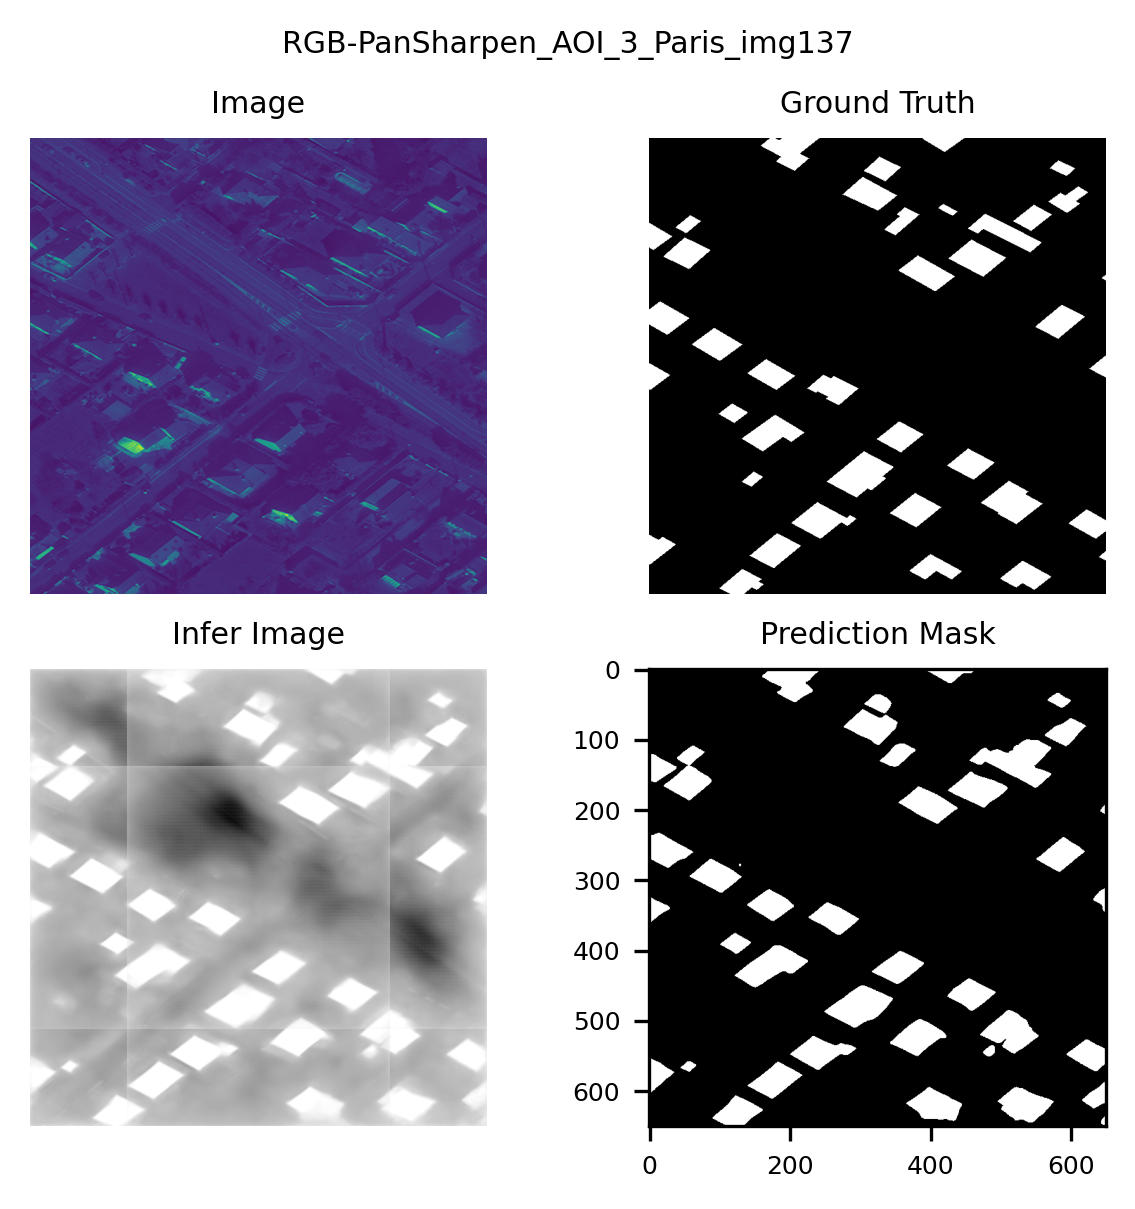

In [4]:
#compare target, ground truth, prediction
import skimage
import skimage.segmentation
import copy
if aois == 6:
    im_list = sorted([z for z in os.listdir(os.path.join(im_dir,'RGB')) if z.endswith('.tif')])
    sample_name= im_list[5]

    gt_path = os.path.join(im_dir, 'masks', sample_name).replace('RGB','GTL')
    image_pt = os.path.join(im_dir, 'RGB', sample_name)
    infer_path = os.path.join(infer_dir+ '/'+ sample_name).replace('RGB-PanSharpen','mask')
    prediction_path = os.path.join(out_dir_mask+ '/'+ sample_name).replace('RGB-PanSharpen','pred_mask')
else : 
    im_list = sorted([z for z in os.listdir(os.path.join(im_dir,'RGB')) if z.endswith('.tif')])
    sample_name= im_list[27]

    gt_path = os.path.join(im_dir, 'masks', sample_name).replace('RGB-PanSharpen','buildings')
    image_pt = os.path.join(im_dir, 'RGB', sample_name)
    if dirmode:
        infer_path = os.path.join(infer_dir+ '/'+ sample_name).replace('RGB-PanSharpen','sum_infer')
    else : 
        infer_path = os.path.join(infer_dir+ '/'+ sample_name).replace('RGB-PanSharpen','mask')
    prediction_path = os.path.join(out_dir_mask+ '/'+ sample_name).replace('RGB-PanSharpen','pred_mask')


img = cv2.imread(image_pt,cv2.IMREAD_UNCHANGED )
img = img.astype(np.uint16)
# cv2.imwrite('processed.tif',img )

gt_image = skimage.io.imread(gt_path)
infer_image = skimage.io.imread(infer_path)
mask_image = skimage.io.imread(prediction_path)
binary = mask_image > 0
# temp_infer = copy.copy(infer_image)
# temp_infer[ temp_infer >=0 ] = 255
# temp_infer[ temp_infer < 0 ] = 0

boundary = skimage.segmentation.find_boundaries(binary, mode='inner', background=0).astype(np.float32)
boundary=boundary*255
print("mask_image.shape:", mask_image.shape)
print("min, max", np.min(mask_image), np.max(mask_image))
print("gt.shape:", gt_image.shape)
print("min, max", np.min(gt_image), np.max(gt_image))
print("infer_image.shape:", infer_image.shape)
print("min, max", np.min(infer_image), np.max(infer_image))
print("boundary:", boundary.shape)
print("min, max", np.min(boundary), np.max(boundary))
#1 boundary ground truth를 255를 곱하자
#2 boundary output에도 255 곱하고.. 그래야 balance가 맞을듯.

print(np.unique(boundary))
fig = plt.figure(figsize=(4,4))
rows=2
cols=2
ax0 = fig.add_subplot(rows, cols, 1)
ax1 = fig.add_subplot(rows, cols, 2)
ax2 = fig.add_subplot(rows, cols, 3)
ax3 = fig.add_subplot(rows, cols, 4)
ax0.imshow(img)
# ax0.imshow(infer_image,cmap='gray')
ax0.axis('off')
ax0.set_title('Image')
ax1.imshow(gt_image,cmap='gray')
ax1.axis('off')
ax1.set_title('Ground Truth')
ax2.imshow(infer_image,cmap='gray')
ax2.axis('off')
ax2.set_title('Infer Image')
ax3.imshow(mask_image,cmap='gray')
#ax3.axis('off')
ax3.set_title('Prediction Mask')
plt.suptitle(sample_name.split('.')[0])
plt.tight_layout()
plt.show()



In [5]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# testy = gt_image/255.
# ns_probs = mask_image

# s_auc = roc_auc_score(testy, ns_probs)
 
# # summarize scores
# #print('No Skill: ROC AUC=%.3f' % (ns_auc))
 
# # calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
 
# # plot the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
 
# # show the plot
# plt.show()


(650, 650)


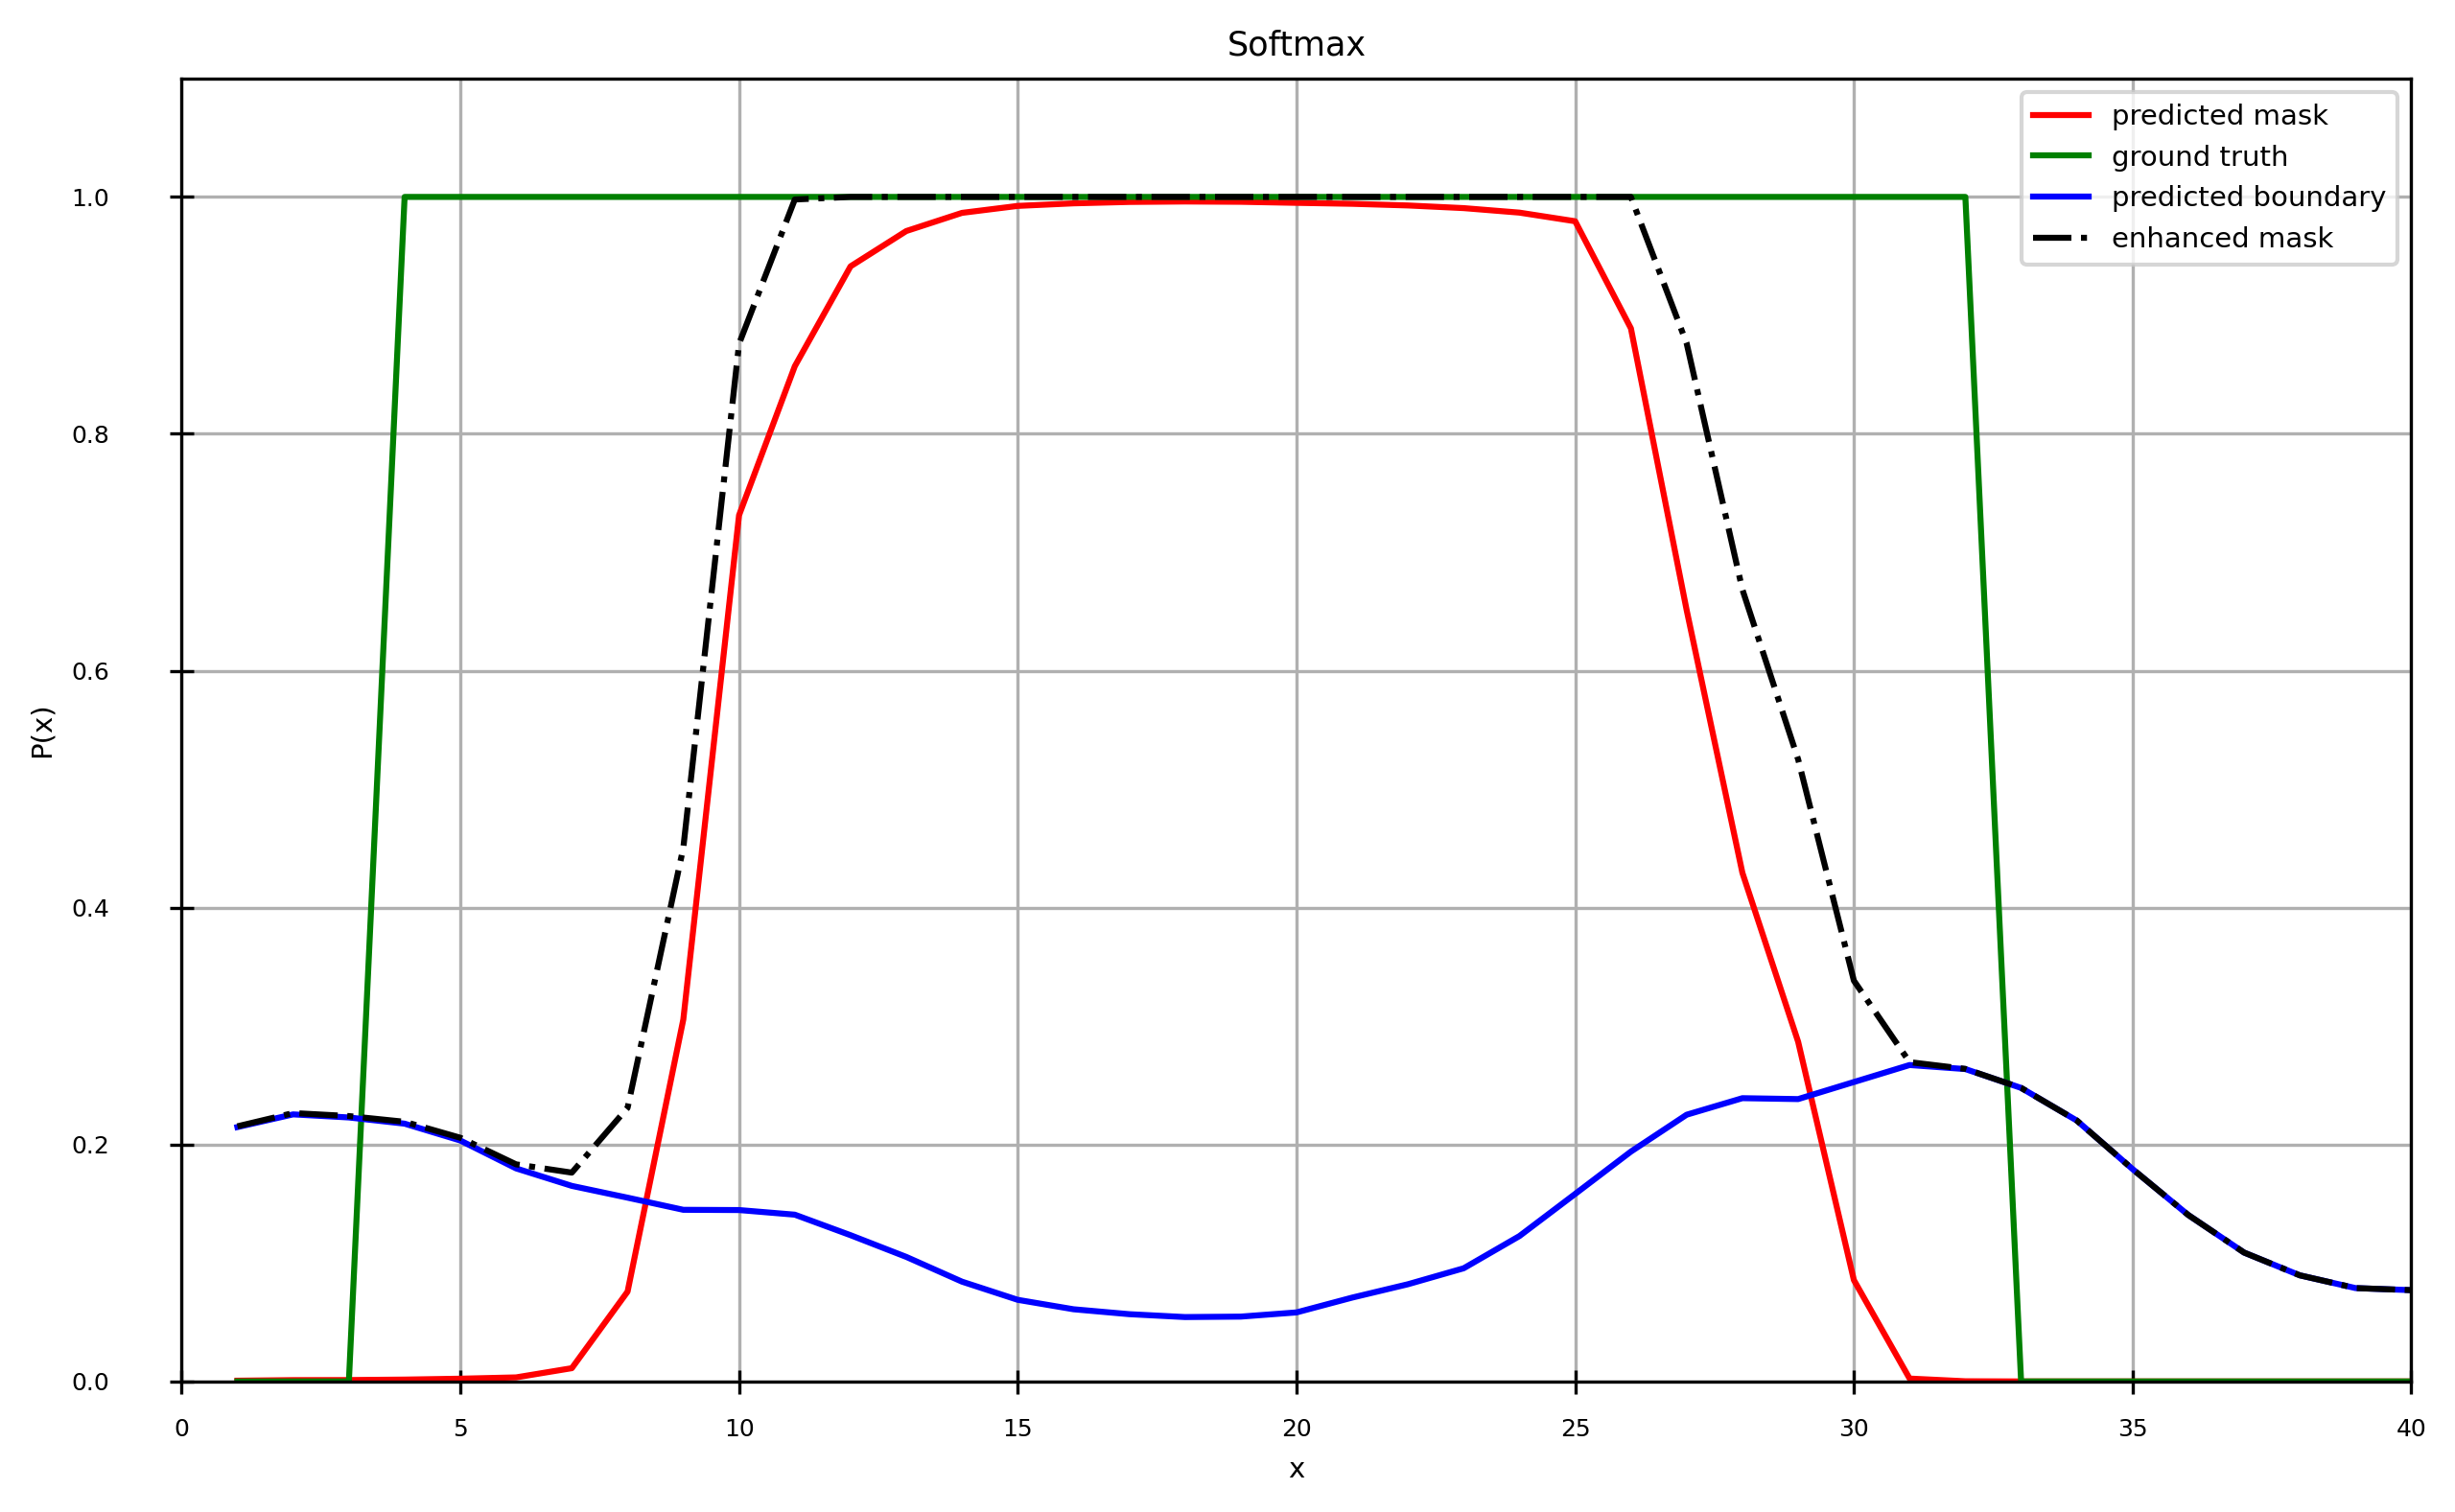

<Figure size 3000x1800 with 0 Axes>

In [11]:

im_list = sorted([z for z in os.listdir(os.path.join(im_dir,'RGB')) if z.endswith('.tif')])
sample_name= im_list[25]
# sample_name= im_list[20]
# sample_name= im_list[1]
# print(sample_name)
gt_path = os.path.join(im_dir, 'masks', sample_name).replace('RGB-PanSharpen','buildings')
image_pt = os.path.join(im_dir, 'RGB', sample_name)
if dirmode:
    infer_path = os.path.join(infer_dir+ '/'+ sample_name).replace('RGB-PanSharpen','sum_infer')
else : 
    infer_path = os.path.join(infer_dir+ '/'+ 'check_mask_presigmoid/'+sample_name).replace('RGB-PanSharpen','sum_infer')
#     infer_path = os.path.join(infer_dir+ '/'+ sample_name).replace('RGB-PanSharpen','mask')
# prediction_path = os.path.join(out_dir_mask+ '/'+ sample_name).replace('RGB-PanSharpen','pred_mask')
boundary_path = os.path.join(infer_dir+ '/'+ 'boundary/'+sample_name).replace('RGB-PanSharpen','Boundary')
sum_path = os.path.join(infer_dir+ '/'+ 'binary/'+sample_name).replace('RGB-PanSharpen','binary')
gt_image2 = skimage.io.imread(gt_path)
infer_image2 = skimage.io.imread(infer_path)
boundary_image = skimage.io.imread(boundary_path)
sum_image = skimage.io.imread(sum_path)

a=200
b=a+40
c=50
# a=480
# b=a+100
# c=250
N=40
X = np.zeros(N)
X[:] = np.linspace(1,N,N)
Y_max = 1.1
y_min=0.0
print(mask_image.shape)
infer_arr = infer_image2[a:b,c]
gt_arr = gt_image2[a:b,c]/255
boundary_arr = boundary_image[a:b,c]
boundary_arr2 = 3*boundary_image[a:b,c]
test_arr =np.clip(boundary_arr2 + infer_arr,0,1)
sum_arr = sum_image[a:b,c]
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams.update({'font.size': 7})

# title of plot
plt.title('Softmax' )

# plotting result graph
plt.xlabel('x')  
plt.ylabel('P(x)') 
plt.xlim(0,N)
plt.ylim(y_min,Y_max)

plt.tick_params(axis='x', direction='inout', length=6, pad=6, labelsize=6)
plt.tick_params(axis='y', direction='inout', length=6, pad=15, labelsize=6,)

plt.plot(X[:], infer_arr,'-r',label='predicted mask')
plt.plot(X[:], gt_arr,'-g',label='ground truth')
# plt.plot(X[:], boundary_arr,'-b',label='boundary')
# plt.plot(X[:], sum_arr,'-k',label='sum(mask+edge)')
plt.plot(X[:], boundary_arr2,'-b',label='predicted boundary')
plt.plot(X[:], test_arr,'-.k',label='enhanced mask')
plt.grid(True)
plt.legend()
fig1=plt.gcf()
plt.show()
plt.draw()
# if not os.path.exists('result_graph'):
#     os.makedirs('result_graph')   
# fig1.savefig(eval_path+'_loss_fig.png',dpi=100)


In [7]:
eval_result = revision_metric(gt_image/255., mask_image/255.)
print(eval_result)

(0.9593254437869823, 0.8461627979840478, 0.9216638389984204, 0.7820949859341386, 0.7333467810759229)


In [8]:
def average(list):
    return (sum(list) / len(list))

eval_path = os.path.join(pred_top_dir+'eval_result'+'/'+aoi+'_'+training_date)
os.makedirs(eval_path, exist_ok=True)
gt_list= sorted([z for z in os.listdir(os.path.join(im_dir,'masks').replace('GTL','RGB')) if z.endswith('.tif')])
# mask_list=sorted([z for z in os.listdir(os.path.join(pred_top_dir,'infer_masks')) if z.endswith('.tif')])
print("list_len : ", len(gt_list))
print(gt_list[0])
eval_list = []
mask_list=[]
acc_list=[]
f1_list = []
rec_list = []
prec_list = []
bal_acc_list=[]
for i,j in enumerate(gt_list) : 
    mask_name = j.split('.')[0]
#     print(mask_name)
    gt_array = skimage.io.imread(os.path.join(im_dir, 'masks',mask_name+'.tif'))
#     eval_mask = os.path.join(out_dir_mask+ '/'+mask_name+'.tif').replace('GTL','RGB')
    eval_mask = os.path.join(out_dir_mask+ '/'+mask_name+'.tif').replace('buildings','pred_mask')
    
#     eval_mask = os.path.join(pred_top_dir, 'infer_masks',mask_name+'.tif').replace('buildings','pred_mask')
    mask_array = skimage.io.imread(eval_mask)
    eval_result = revision_metric(gt_array/255., mask_array/255.)
    
#     print("accuracy : %.3f " % eval_result[0], end=',')
#     print("f1_score : %.3f " % eval_result[1], end=',')
#     print("recall : %.3f " % eval_result[2], end=',')
#     print("precision : %.3f " % eval_result[3])
    
    acc_list.append(eval_result[0])
    f1_list.append(eval_result[1])
    rec_list.append(eval_result[2])
    prec_list.append(eval_result[3])
    bal_acc_list.append(eval_result[4])



acc_list_nonzero = [i for i in acc_list if i > 0 ] 
f1_list_nonzero = [i for i in f1_list if i > 0 ]    
rec_list_nonzero = [i for i in rec_list if i > 0 ]    
prec_list_nonzero = [i for i in prec_list if i > 0 ]  
bal_acc_list_nonzero = [i for i in bal_acc_list if i > 0 ]  


a=round(average(acc_list),5)
b=round(average(f1_list),5)
c=round(average(rec_list),5)
d=round(average(prec_list),5)
e=round(average(acc_list_nonzero),5)
f=round(average(f1_list_nonzero),5)
g=round(average(rec_list_nonzero),5)
h=round(average(prec_list_nonzero),5)

x=round(average(bal_acc_list),5)
y= round(average(bal_acc_list_nonzero),5)


print("accuray = %.5f  / %.5f" % (a,e))
print("precision = %.5f / %.5f" % (d, h))
print("recall = %.5f / %.5f" % (c, g))
print("f1_score = %.5f / %.5f" % (b, f))



eval_df = pd.DataFrame(columns=['file_name','accuracy',  'precision', 'recall', 'f1_score','bal_accuracy'])
eval_df.loc[0] = ("Average",a,d,c,b,x)
eval_df.loc[1] = ("Average(nonzero)",e,h,g,f,y)
eval_result = pd.DataFrame([x for x in zip(gt_list,acc_list, prec_list, rec_list, f1_list,bal_acc_list )], columns=['file_name','accuracy',  'precision', 'recall', 'f1_score', 'bal_accuracy'])    
evaldf = eval_df.append(eval_result)

evaldf.to_csv(eval_path+"_eval_result.csv",mode='w')
evaldf

list_len :  172
buildings_AOI_3_Paris_img10.tif


/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/hoyin/anaconda3/envs/solaris2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hoyin/anaconda3/envs/solaris2/lib/pyth

accuray = 0.97488  / 0.97488
precision = 0.56066 / 0.82422
recall = 0.54719 / 0.80442
f1_score = 0.54596 / 0.80260


,file_name,accuracy,precision,recall,f1_score,bal_accuracy
0,Average,0.974880,0.560660,0.547190,0.545960,0.463690
1,Average(nonzero),0.974880,0.824220,0.804420,0.802600,0.681670
0,buildings_AOI_3_Paris_img10.tif,1.000000,0.000000,0.000000,0.000000,0.000000
1,buildings_AOI_3_Paris_img100.tif,0.967389,0.798770,0.893727,0.843585,0.729482
2,buildings_AOI_3_Paris_img101.tif,0.961049,0.814520,0.905739,0.857711,0.750870
...,...,...,...,...,...,...
167,buildings_AOI_3_Paris_img94.tif,1.000000,0.000000,0.000000,0.000000,0.000000
168,buildings_AOI_3_Paris_img95.tif,1.000000,0.000000,0.000000,0.000000,0.000000
169,buildings_AOI_3_Paris_img96.tif,0.964956,0.826950,0.777031,0.801214,0.668354
170,buildings_AOI_3_Paris_img98.tif,1.000000,0.000000,0.000000,0.000000,0.000000


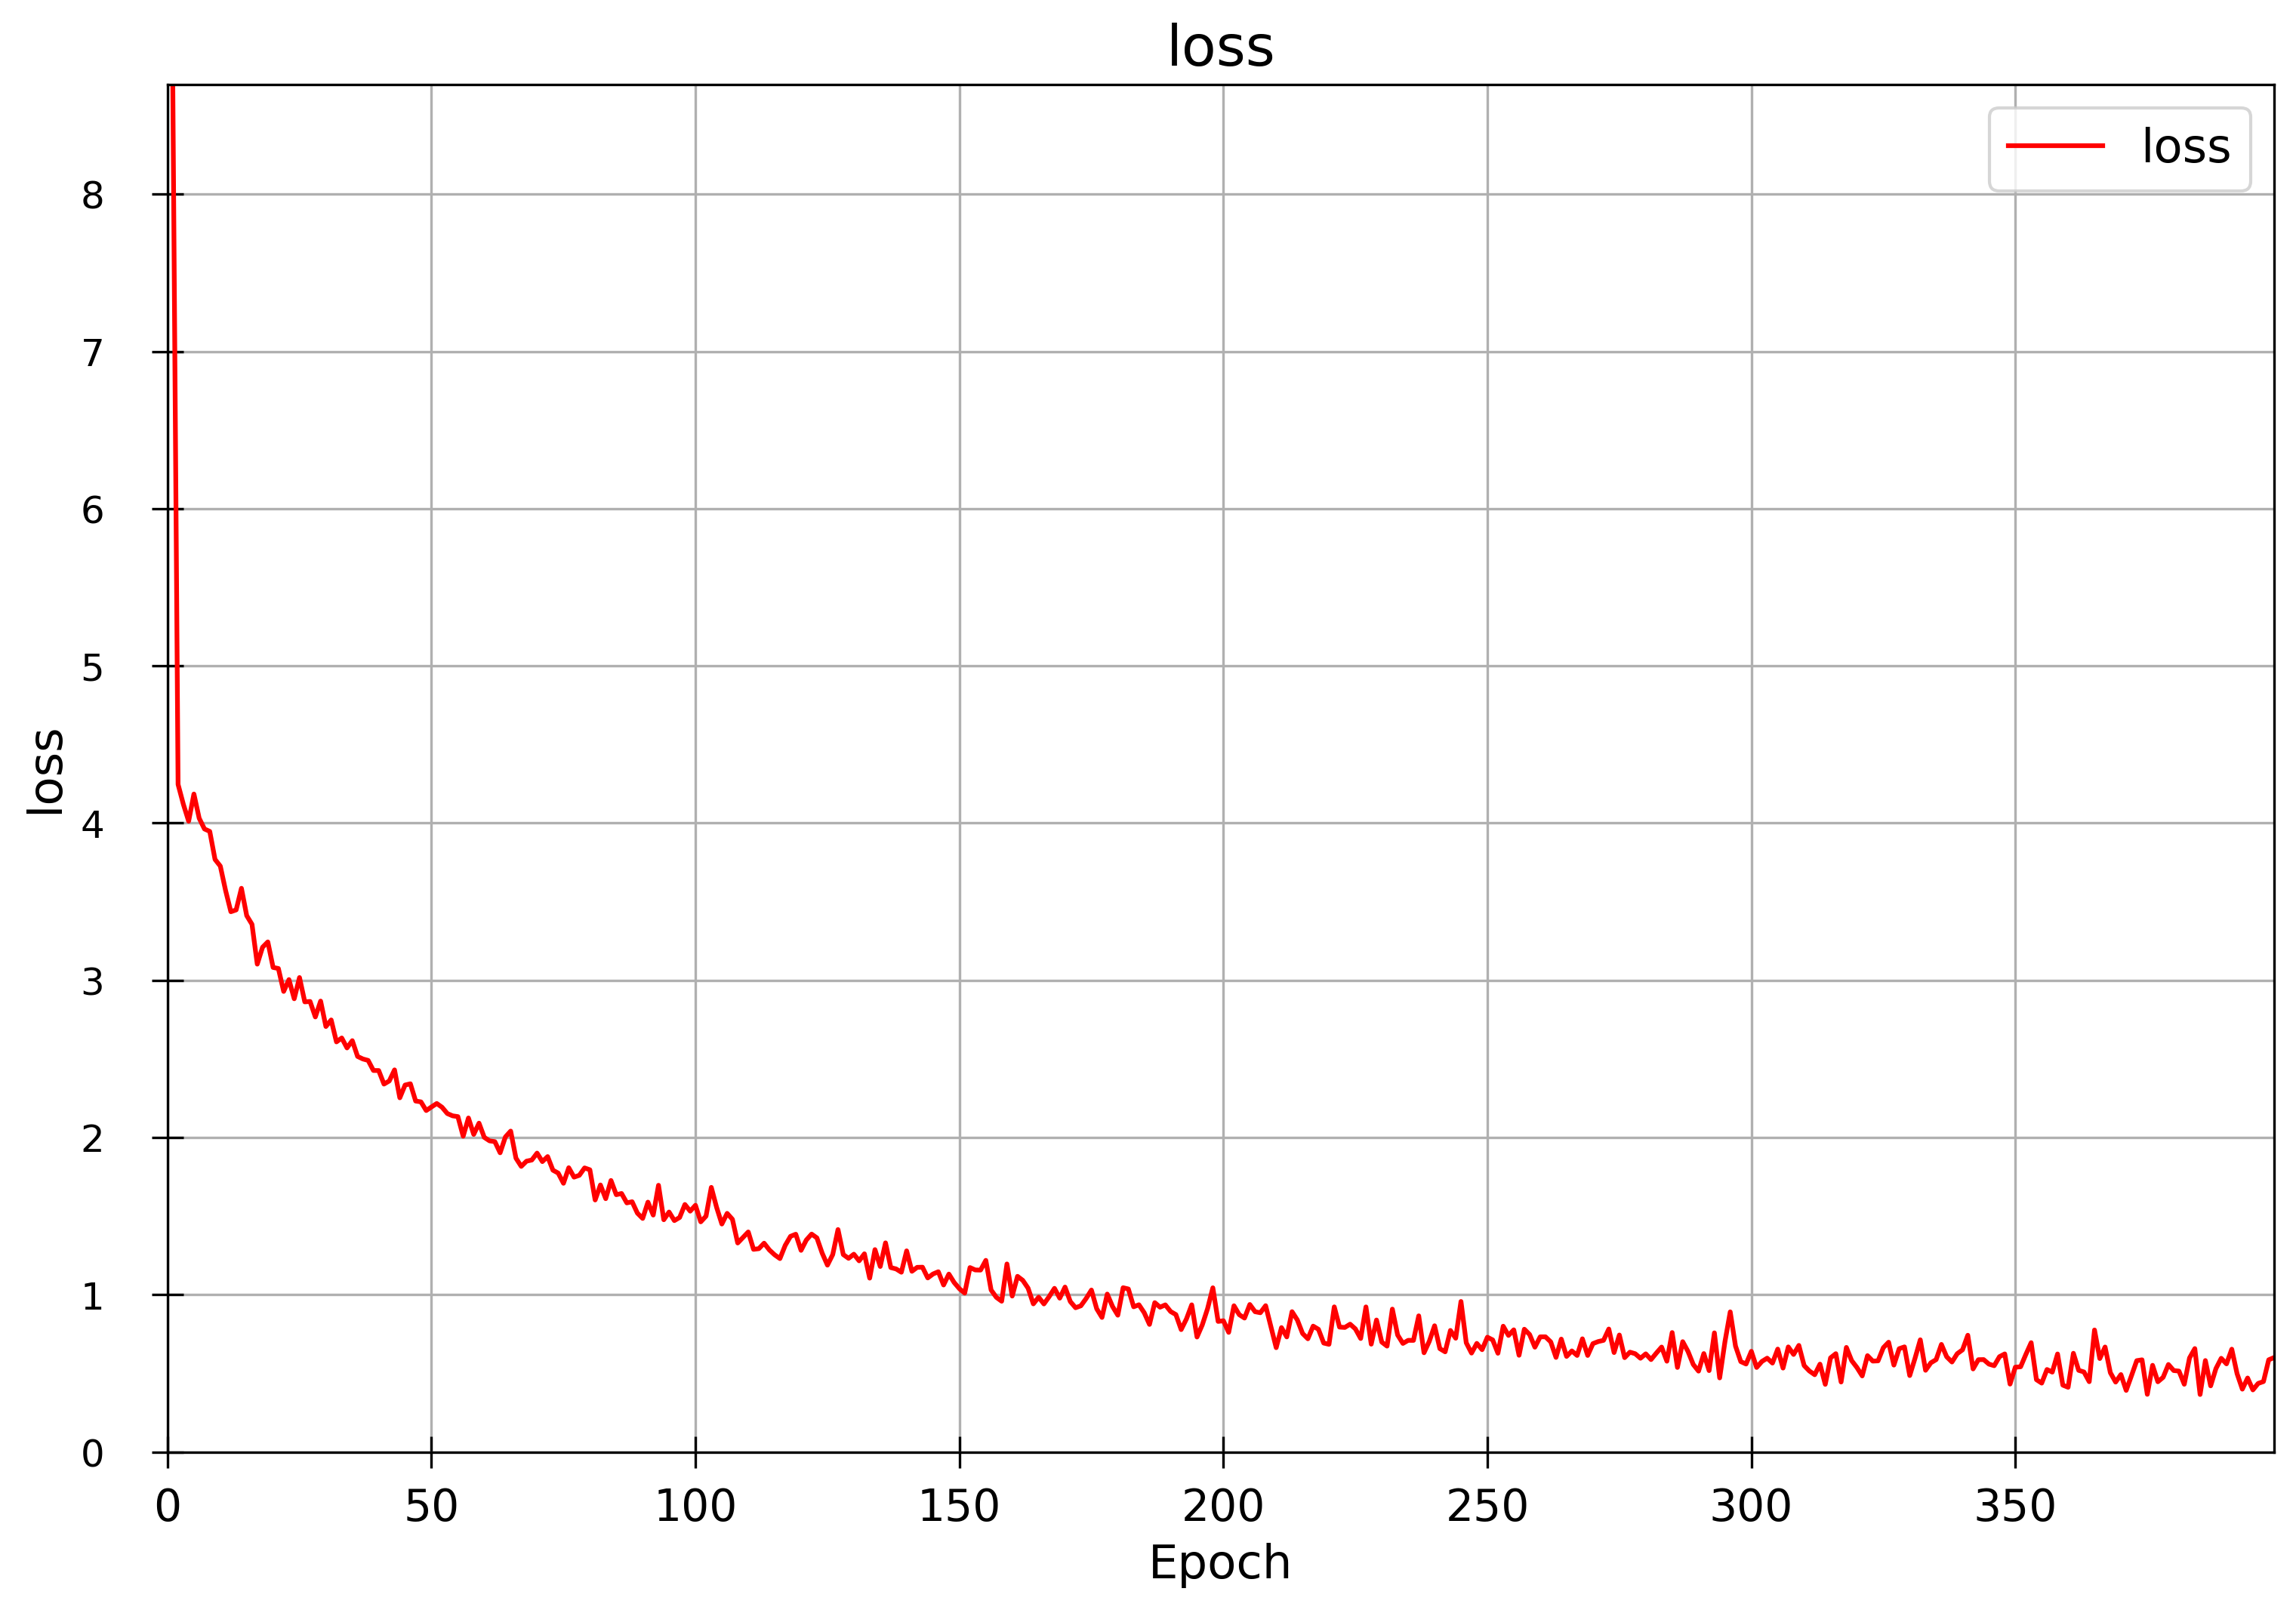

<Figure size 3600x2400 with 0 Axes>

In [9]:


loss_dir = '../result/models_weight/' +aoi + '_' + training_date+'/'
loss_file = loss_dir + 'loss_val_save.csv'
loss = pd.read_csv(loss_file)
loss_arr = loss.values
loss.to_csv(eval_path+"_loss_graph.csv",mode='w')
N=len(loss_arr)
X = np.zeros(N)
X[:] = np.linspace(1,N,N)
Y_max = max(loss_arr)


y_min=min(loss_arr)
# y_min=0.1
# Y_max = 0.5
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams.update({'font.size': 15})

# title of plot
plt.title('loss' )

# plotting result graph
plt.xlabel('Epoch')  
plt.ylabel('loss') 
plt.xlim(0,N)
plt.ylim(0,Y_max)

plt.tick_params(axis='x', direction='inout', length=10, pad=6, labelsize=14)
plt.tick_params(axis='y', direction='inout', length=10, pad=15, labelsize=12,)

plt.plot(X[:], loss_arr,'-r',label='loss')
plt.grid(True)
plt.legend()
fig1=plt.gcf()
plt.show()
plt.draw()
# if not os.path.exists('result_graph'):
#     os.makedirs('result_graph')   
fig1.savefig(eval_path+'_loss_fig.png',dpi=100)



In [10]:

# id_list = ['292053','1311818','129949','251549','2191020','2201539'] #상하이
id_list = ['1141937','125830','128234','232358','2191020','2211227']
# aoi = 'AOI_4_Shanghai_'
aoi = 'AOI_5_Khartoum_'
pic_num = '540'
# pic_num = '182'
result_img_list = []
for id_ in id_list :
    result_img = os.path.join('../result/infer_masks/'+aoi+id_+'/'+'pred_mask_'+aoi+'img'+pic_num+'.tif')
    result_img_list.append(result_img)
# print(result_img_list)
unet = skimage.io.imread(result_img_list[0])
unet_be= skimage.io.imread(result_img_list[1])
resunet= skimage.io.imread(result_img_list[2])
resunet_be= skimage.io.imread(result_img_list[3])
ternaus= skimage.io.imread(result_img_list[4])
ternaus_be= skimage.io.imread(result_img_list[5])

origin_path = '../data/Test/'+aoi+'Test/'
gt_imgae = skimage.io.imread(os.path.join(origin_path+'masks/buildings_'+aoi+'img'+pic_num+'.tif'))
rgb_imgae = skimage.io.imread(os.path.join(origin_path+'RGB/RGB-PanSharpen_'+aoi+'img'+pic_num+'.tif'))
# rgb_imgae = cv2.imread((os.path.join(origin_path+'RGB/RGB-PanSharpen_'+aoi+'img'+pic_num+'.tif',cv2.IMREAD_UNCHANGED )))
# rgb_imgae = rgb_imgae.astype(np.uint16)
# fig = plt.figure(figsize=(4,4))
fig = plt.figure(figsize=(8,16))
rows=4
cols=2
ax0 = fig.add_subplot(rows, cols, 1)
ax1 = fig.add_subplot(rows, cols, 2)
ax2 = fig.add_subplot(rows, cols, 3)
ax3 = fig.add_subplot(rows, cols, 4)
ax4 = fig.add_subplot(rows, cols, 5)
ax5 = fig.add_subplot(rows, cols, 6)
ax6 = fig.add_subplot(rows, cols, 7)
ax7 = fig.add_subplot(rows, cols, 8)


ax0.imshow(unet,cmap='gray')
ax0.axis('off')
ax0.set_title('unet')

ax1.imshow(unet_be,cmap='gray')
ax1.axis('off')
ax1.set_title('unet_be')

ax2.imshow(resunet,cmap='gray')
ax2.axis('off')
ax2.set_title('resunet')

ax3.imshow(resunet_be,cmap='gray')
ax3.axis('off')
ax3.set_title('resunet_be')

ax4.imshow(ternaus,cmap='gray')
ax4.axis('off')
ax4.set_title('ternaus')

ax5.imshow(ternaus_be,cmap='gray')
ax5.axis('off')
ax5.set_title('ternaus_be')

ax6.imshow(rgb_imgae,cmap='gray')
ax6.axis('off')
ax6.set_title('rgb_imgae')

ax7.imshow(gt_imgae,cmap='gray')
ax7.axis('off')
ax7.set_title('gt_imgae')
plt.suptitle(pic_num)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/hoyin/spacenet/result/infer_masks/AOI_5_Khartoum_1141937/pred_mask_AOI_5_Khartoum_img540.tif'

In [ ]:
import shutil

shutil.copy(os.path.join(origin_path+'RGB/RGB-PanSharpen_'+aoi+'img'+pic_num+'.tif'), '../result/ppt/'+aoi+'rgb'+'.png')
count=0
for id_ in id_list:
#     result_img_list
    skimage.io.imsave('../result/ppt/'+aoi+id_+'.png', skimage.io.imread(result_img_list[count]))
    count += 1
skimage.io.imsave('../result/ppt/'+aoi+'gt'+'.png',gt_imgae)
# skimage.io.imsave('../result/ppt/'+aoi+'rgb'+'.png', rgb_imgae)
# skimage.io.imsave('../result/ppt/'+aoi+'gt'+'.png', os.path.join(origin_path+'masks/buildings_'+aoi+'img'+pic_num+'.tif'))
# skimage.io.imsave('../result/ppt/'+aoi+'rgb'+'.png', os.path.join(origin_path+'RGB/RGB-PanSharpen_'+aoi+'img'+pic_num+'.tif'))

# gt_imgae = skimage.io.imread(os.path.join(origin_path+'masks/buildings_'+aoi+'img'+pic_num+'.tif'))
# rgb_imgae

In [ ]:
# import tifffile as tiff
# a = tiff.imread(os.path.join(origin_path+'RGB/RGB-PanSharpen_'+aoi+'img'+pic_num+'.tif'))
# # tiff.imsave('../result/ppt/'+aoi+'rgb22'+'.png', a)
# a2 = a.astype(np.uint8)
# skimage.io.imsave('../result/ppt/'+aoi+'rgb'+'.png', a2)